In [2]:
import talib
import pandas as pd
import numpy as np

import itertools
import operator # 运算符代替库
from jqdata import *

import seaborn as sns
from pylab import mpl
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

plt.style.use('seaborn')

# 准备分析用函数

In [3]:
###################################################################################
# 回测框架
# 获取信号进行回测
class DiffusionIndicatorBackTest(object):
    '''
    close_df:index-date,columns-codes
    mkt_cap_df:index-date,columns-codes
    singal_ser:pd.Series或者func 在method参数为ls时 singal_ser需要为func
    cal_func:平滑N1,N2的计算方式
    N,N1,N2:如研报描述
    method:long多头,short空头,ls多空
    ==================
    return dict
        fast_ma:pd.Series
        slow_ma:pd.Series
        flag:np.array 1为多头 0为无持仓 -1为空头
        algorithm_returns:策略收益率
        algorithm_cum:策略净值
    '''

    def __init__(self, symbol: str, singal_ser: pd.Series, start_date: str,
                 end_date: str, cal_func, N1: int, N2: int, method: str):

        self.symbol = symbol
        self.singal_func = singal_ser
        self.start_date = start_date
        self.end_date = end_date
        self.cal_func = cal_func
        self.N1 = N1
        self.N2 = N2
        self.method = method
        
        self.singal = pd.Series()
        self.index_price = pd.Series()
        self.algorithm_returns = pd.Series()  # 策略收益
        self.algorithm_cum = pd.Series()  # 策略净值

        self.flag = np.array([])  # 持仓标记
        self.fast_ma = pd.Series()
        self.slow_ma = pd.Series()

    def backtest(self):

        # 获取指数下期收益率用于回测
        offset_end = TdaysOffset(self.end_date, 1)

        # 数据获取
        close_df = get_price(
            self.symbol,
            self.start_date,
            offset_end,
            fields=['close', 'pre_close'],
            panel=False)

        # 计算收益率
        pct_chg = close_df['close'] / close_df['pre_close'] - 1
        next_ret = pct_chg.shift(-1)
        next_ret = next_ret.loc[self.start_date:self.end_date]

        # 计算指数净值
        self.index_price = close_df['close']
        
        # 多空
        if self.method == 'ls':
            
            self._CalLs(next_ret) # 多空的计算处理
            

        else:
            self._checksingalfunc()
            self._GetFlag()  # 获取持仓标记

            self.CalAlgorithmCum(next_ret)  # 获取策略净值
    
    
    # 计算多空
    def _CalLs(self,next_ret):
        
        n = len(next_ret)
        flag = np.zeros((2,n))
        ret = np.zeros(n)
        
        for i,md in enumerate(['long','short']):
            
            self.method = md
            self._checksingalfunc()     # 获取信号
            self._GetFlag() # 获取持仓标记
            self.CalAlgorithmCum(next_ret)
        
            ret += self.algorithm_returns # 多空收益
            flag[i] = self.flag
            
        self.flag = flag
        self.algorithm_returns = ret
        self.algorithm_cum = (1 + self.algorithm_returns).cumprod() # 计算累计收益率
        
        self.method = 'ls' # 将其该会原始状态
        
    # 检查singal_ser格式
    def _checksingalfunc(self):
        
        if hasattr(self.singal_func, '__call__') :
            
            self.singal = self.singal_func(self.method)
            
        elif self.method and self.method != 'ls':
            
            self.singal = self.singal_func
            
        else:
            
            raise ValueError('多空方法下singal_ser需要传入计算方法而非pd.Series')
            

    # 标记持仓
    def _GetFlag(self) -> np.array:

        #fast_ma = self.singal_ser.rolling(self.N1).mean()
        #slow_ma = fast_ma.rolling(self.N2).mean()

        fast_ma = self.cal_func(self.singal, self.N1)
        slow_ma = self.cal_func(fast_ma, self.N2)

        self.fast_ma = fast_ma.loc[self.start_date:self.end_date]
        self.slow_ma = slow_ma.loc[self.start_date:self.end_date]

        if self.method == 'long':

            self.flag = np.where(self.fast_ma > self.slow_ma, 1, 0)

        elif self.method == 'short':

            self.flag = np.where(self.fast_ma > self.slow_ma, -1, 0)

        else:

            raise ValueError('多空参数仅能为:long,short')

    # 计算收益率等风险指标
    def CalAlgorithmCum(self, next_ret: pd.Series):
    
        algorithm_returns = self.flag * next_ret
        algorithm_cum = (1 + algorithm_returns).cumprod()

        self.algorithm_returns = algorithm_returns
        self.algorithm_cum = algorithm_cum

        
    # 获取收益指标
    def GetRisk(self) -> dict:

        # 年化收益率
        annual_algo_return = pow(self.algorithm_cum[-1] / self.algorithm_cum[0],
                                 250 / len(self.algorithm_cum)) - 1

        # 策略波动率
        algorithm_volatility = self.algorithm_returns.std() * np.sqrt(250)

        # 夏普
        sharpe = (annual_algo_return - 0.04) / algorithm_volatility

        # 最大回撤点，最大回撤
        md_p, md_r = self._GetMaxDrawdown()
        md_date_range = '{}-{}'.format(
            self.algorithm_cum.index[md_p[1]].strftime('%Y%m%d'),
            self.algorithm_cum.index[md_p[0]].strftime('%Y%m%d'))
                
        # 交易次数，胜率
        trade, winratio = self.TradeCount()

        return {
            '交易次数': trade,
            '胜率': winratio,
            '累计净值': round(self.algorithm_cum[-1], 4),
            '年化收益率': round(annual_algo_return, 4),
            '年化波动率': round(algorithm_volatility, 4),
            '夏普': round(sharpe, 4),
            '最大回撤': round(md_r, 4),
            '回撤时间': md_date_range,
            '收益回撤比': round(annual_algo_return / md_r, 4)
        }

    # 获取最大回撤
    def _GetMaxDrawdown(self) -> tuple:
        '''
        algorithm_cum
        ===========
        return 最大回撤位置,最大回撤
        '''
        arr = self.algorithm_cum.values
        i = np.argmax((np.maximum.accumulate(arr) - arr) /
                      np.maximum.accumulate(arr))  # end of the period
        j = np.argmax(arr[:i])  # start of period
        return ([i, j], (1 - arr[i] / arr[j]))  # 回撤点，回撤比率
    
    # 获取交易次数、胜率
    def TradeCount(self):
        
        if self.method == 'ls':
            
            num = 0
            w_num = 0
            
            for flag in self.flag:
                
                open_num,win, wincount = self._GetWinCount(flag)
                num += open_num
                w_num += win
                
            return num, w_num / num # 交易次数，胜率
        
        else:
            
            open_num,win, wincount = self._GetWinCount(self.flag)
            
            return open_num,wincount
        
    # TradeCound的底层计算
    def _GetWinCount(self,flag):
        '''
        统计
        '''  
            
        flag = np.abs(flag)
        # 交易次数 1为开仓 -1为平仓
        trade_num = flag - np.insert(flag[:-1], 0, 0)

        # 交易次数
        open_num = sum(trade_num[trade_num == 1])

        # 统计开仓收益
        temp_df = pd.DataFrame({
            'flag': flag,
            'algorithm_returns': self.algorithm_returns
        })

        temp_df['mark'] = (temp_df['flag'] != temp_df['flag'].shift(1))
        temp_df['mark'] = temp_df['mark'].cumsum()

        # 开仓至平仓的持有收益
        tradecumsumratio = temp_df.query('flag==1').groupby(
            'mark')['algorithm_returns'].sum()
        win = len(tradecumsumratio[tradecumsumratio > 0])

        wincount = round(win / open_num, 4)

        return open_num,win, wincount  # 交易次数，盈利次数,胜率


###################################################################################

# 画信号图
def IndicatorPlot(index_price: pd.Series, fast_ma: pd.Series,
                  slow_ma: pd.Series, flag: np.array):
    '''
    index_price:index为date value为指数价格
    fast_ma:index为date value为快指标
    slow_ma:index为date value为慢指标
    ==========
    return 图表
    '''
    plt.rcParams['font.family'] = 'serif'

    # 标记点
    idx = list(range(len(flag)))
    marks = np.where(flag == 1, idx, 0)
    marks = marks[marks != 0].tolist()

    # 画图
    fig = plt.figure(figsize=(18, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('持仓标记')

    index_price.plot(markevery=marks, marker='o', mfc='r', ms=2)
    plt.legend()

    ax2 = fig.add_subplot(212)
    ax2.set_title('信号')
    fast_ma.plot()
    slow_ma.plot()
    plt.legend(['fast_ma', 'slow_ma'])
    plt.show()


# 画净值
def CumPlot(index_price: pd.Series, algorithm_cum: pd.Series, title: str):
    '''
    index_price:index为date value为指数价格
    algorithm_cum:index为date value为净值
    title:图表标题
    ==========
    return 图表
    '''
    plt.rcParams['font.family'] = 'serif'
    plt.figure(figsize=(18, 8))
    plt.title(title)

    if isinstance(algorithm_cum, list):
        for cum in algorithm_cum:

            cum.plot(
                markevery=GetMaxDrawdown(cum),
                marker='^',
                mec='black',
                mew=2,
                mfc='g',
                ms=7,
                label=cum.name)
        (index_price / index_price[0]).plot(
            ls='--', color='SteelBlue', alpha=0.6, label='benchmark_return')
        plt.legend()

    else:

        algorithm_cum.plot(
            markevery=GetMaxDrawdown(algorithm_cum),
            marker='^',
            mec='black',
            mew=2,
            mfc='g',
            ms=7)

        (index_price / index_price[0]).plot(
            ls='--', color='SteelBlue', alpha=0.6)
        plt.legend(['algorithm_return', 'benchmark_return'])


###################################################################################

def GetMaxDrawdown(algorithm_cum) -> list:
    '''
        algorithm_cum
        ===========
        return 最大回撤位置
        '''
    arr = algorithm_cum.values
    i = np.argmax((np.maximum.accumulate(arr) - arr) /
                  np.maximum.accumulate(arr))  # end of the period
    j = np.argmax(arr[:i])  # start of period
    return [i, j]  # 回撤点


def TdaysOffset(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]

    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')


###################################################################################

# 获取MA扩散指标信号
def CreatMaSingal(index_symbol: str, start_date: str, end_date: str, N, N1,
                  weight_method: str, method: str) -> pd.Series:
    '''
    N,N1的作用只是去前序计算期
    method:short空头,long多头
    weight_method:avg等权,mktcap市值加权
    '''
    # 数据计算前序期
    begin_date = TdaysOffset(
        start_date,
        -(N + N1),
    )

    # 成分股使用end_date时点成分股
    security_list = get_index_stocks(index_symbol, date=end_date)

    ## 前复权数据
    close_df = get_price(
        security_list, begin_date, end_date, fields='close', panel=False)
    close_df = pd.pivot_table(
        close_df, index='time', columns='code', values='close')

    # 计算均线
    ma_df = close_df.rolling(N).mean()
    action = {'long': operator.gt, 'short': operator.lt}

    if weight_method == 'avg':

        return (action[method](close_df, ma_df)).sum(axis=1)

    elif weight_method == 'mktcap':

        ## 获取流通市值
        mak_cap_df = GetValuation(
            security_list, start_date=begin_date, end_date=end_date)
        mak_cap_df = pd.pivot_table(
            mak_cap_df,
            index='day',
            columns='code',
            values='circulating_market_cap')

        weights = mak_cap_df.apply(lambda x: x / x.sum(), axis=1).fillna(0)
        return (action[method](close_df, ma_df) * weights).sum(axis=1)

# 获取ROC扩散指标信号
def CreatROCSingal(index_symbol: str, start_date: str, end_date: str, N, N1,
                  weight_method: str, method: str) -> pd.Series:
    '''
    N,N1的作用只是去前序计算期
    method:short空头,long多头
    weight_method:avg等权,mktcap市值加权
    '''
    # 数据计算前序期
    begin_date = TdaysOffset(
        start_date,
        -(N + N1),
    )

    # 成分股使用end_date时点成分股
    security_list = get_index_stocks(index_symbol, date=end_date)

    ## 前复权数据
    close_df = get_price(
        security_list, begin_date, end_date, fields='close', panel=False)
    close_df = pd.pivot_table(
        close_df, index='time', columns='code', values='close')

    # 计算roc
    pct_chg = close_df.pct_change(N)
    action = {'long': operator.gt, 'short': operator.lt}

    if weight_method == 'avg':

        return (action[method](pct_chg, 0)).sum(axis=1)

    elif weight_method == 'mktcap':

        ## 获取流通市值
        mak_cap_df = GetValuation(
            security_list, start_date=begin_date, end_date=end_date)
        mak_cap_df = pd.pivot_table(
            mak_cap_df,
            index='day',
            columns='code',
            values='circulating_market_cap')

        weights = mak_cap_df.apply(lambda x: x / x.sum(), axis=1).fillna(0)
        return (action[method](pct_chg, 0) * weights).sum(axis=1)

# 获取KDJ扩散指标信号
def CreatKDJSingal(index_symbol: str, start_date: str, end_date: str, N, N1,
                  weight_method: str, method: str) -> pd.Series:
    '''
    N,N1的作用只是去前序计算期
    method:short空头,long多头
    weight_method:avg等权,mktcap市值加权
    '''
    # 数据计算前序期
    begin_date = TdaysOffset(
        start_date,
        -(N + N1),
    )

    # 成分股使用end_date时点成分股
    security_list = get_index_stocks(index_symbol, date=end_date)

    ## 前复权数据
    close_df = get_price(
        security_list, begin_date, end_date, fields=['close','high','low'], panel=False)
    
    # 计算获取kd值
    kd = close_df.groupby('code',group_keys=False).apply(cal_kd,fastk_period=N)
    df = pd.concat([close_df[['time','code']],kd],axis=1)

    # 获取k,d
    slowk = pd.pivot_table(df,index='time',columns='code',values='k')
    slowd = pd.pivot_table(df,index='time',columns='code',values='d')
    
    action = {'long': operator.gt, 'short': operator.lt}

    if weight_method == 'avg':

        return (action[method](slowk, slowd)).sum(axis=1)

    elif weight_method == 'mktcap':

        ## 获取流通市值
        mak_cap_df = GetValuation(
            security_list, start_date=begin_date, end_date=end_date)
        
        mak_cap_df = pd.pivot_table(
            mak_cap_df,
            index='day',
            columns='code',
            values='circulating_market_cap')

        weights = mak_cap_df.apply(lambda x: x / x.sum(), axis=1).fillna(0)
        return (action[method](slowk, slowd) * weights).sum(axis=1)
    
# 计算KD
def cal_kd(df,fastk_period:int):
    
    k,d = talib.STOCH(df['high'],
                      df['low'],
                      df['close'],
                      fastk_period=fastk_period, 
                      slowk_period=3, 
                      slowd_period=3)
    
    df = pd.concat([k,d],axis=1)
    df.columns = ['k','d']
    return df

# 获取RSI扩散指标信号
def CreatRSISingal(index_symbol: str, start_date: str, end_date: str, N, N1,
                  weight_method: str, method: str) -> pd.Series:
    '''
    N,N1的作用只是去前序计算期
    method:short空头,long多头
    weight_method:avg等权,mktcap市值加权
    '''
    # 数据计算前序期
    begin_date = TdaysOffset(
        start_date,
        -(N + N1),
    )

    # 成分股使用end_date时点成分股
    security_list = get_index_stocks(index_symbol, date=end_date)

    ## 前复权数据
    close_df = get_price(
        security_list, begin_date, end_date, fields='close', panel=False)
    
    # 计算获取RSI
    close_df['rsi'] = close_df.groupby('code')['close'].transform(talib.RSI,timeperiod=N)
    rsi = pd.pivot_table(close_df,index='time',columns='code',values='rsi')
    
    action = {'long': operator.gt, 'short': operator.lt}
    limit = {'long':70,'short':30}
    
    if weight_method == 'avg':
    
        return (action[method](rsi, limit[method])).sum(axis=1)

    elif weight_method == 'mktcap':

        ## 获取流通市值
        mak_cap_df = GetValuation(
            security_list, start_date=begin_date, end_date=end_date)
        
        mak_cap_df = pd.pivot_table(
            mak_cap_df,
            index='day',
            columns='code',
            values='circulating_market_cap')

        weights = mak_cap_df.apply(lambda x: x / x.sum(), axis=1).fillna(0)
        
        return (action[method](rsi, limit[method]) * weights).sum(axis=1)
    
# 突破N日高点
def CreatStageHighSingal(index_symbol: str, start_date: str, end_date: str, N, N1,
                  weight_method: str, method: str) -> pd.Series:
    '''
    N,N1的作用只是去前序计算期
    method:short空头,long多头
    weight_method:avg等权,mktcap市值加权
    '''
    # 数据计算前序期
    begin_date = TdaysOffset(
        start_date,
        -(N + N1),
    )

    # 成分股使用end_date时点成分股
    security_list = get_index_stocks(index_symbol, date=end_date)

    ## 前复权数据
    data = get_price(
        security_list, begin_date, end_date, fields=['close','pre_close'], panel=False)
    
    close_df = pd.pivot_table(
        data, index='time', columns='code', values='close')
    
    pre_close = pd.pivot_table(
        data, index='time', columns='code', values='pre_close')
    
    roll_max = pre_close.rolling(N).max()
    
    # 计算均线
    action = {'long': operator.gt, 'short': operator.lt}

    if weight_method == 'avg':

        return (action[method](close_df, roll_max)).sum(axis=1)

    elif weight_method == 'mktcap':

        ## 获取流通市值
        mak_cap_df = GetValuation(
            security_list, start_date=begin_date, end_date=end_date)
        mak_cap_df = pd.pivot_table(
            mak_cap_df,
            index='day',
            columns='code',
            values='circulating_market_cap')

        weights = mak_cap_df.apply(lambda x: x / x.sum(), axis=1).fillna(0)
        return (action[method](close_df, roll_max) * weights).sum(axis=1)
    
# 市值数据获取
def GetValuation(symbol: list, start_date: str, end_date: str) -> pd.DataFrame:

    dates = get_trade_days(start_date, end_date)

    limit = 10000
    n_symbols = len(symbol)
    n_days = len(dates)

    if n_symbols * n_days > limit:

        n = limit // n_symbols
        df_list = []
        i = 0
        pos1, pos2 = n * i, n * (i + 1) - 1

        while pos2 < n_days:

            df = get_valuation(
                symbol,
                start_date=dates[pos1],
                end_date=dates[pos2],
                fields='circulating_market_cap')
            df_list.append(df)
            i += 1
            pos1, pos2 = n * i, n * (i + 1) - 1
        if pos1 < n_days:
            df = get_valuation(
                symbol,
                start_date=dates[pos1],
                end_date=dates[-1],
                fields='circulating_market_cap')
            df_list.append(df)
        df = pd.concat(df_list, axis=0)
    else:
        df = get_valuation(
            symbol,
            start_date=start_date,
            end_date=end_date,
            fields='circulating_market_cap')
    return df


###################################################################################

# 网格寻参大法
def GetGridRiskReport(N: int, singal_ser: pd.Series,N1S:int=20,N2S:int=10):

    risk_list = []
    for j in range(20, N, 10):
        for i in range(10, j, 5):

            bt = DiffusionIndicatorBackTest(
                symbol=index_symbol,
                singal_ser=singal_ser,
                start_date=start_date,
                end_date=end_date,
                cal_func=talib.MA,
                N1=j,
                N2=i,
                method='long')

            bt.backtest()

            risk = pd.Series(bt.GetRisk())
            risk.name = '{}_{}_{}'.format(N, j, i)
            risk_list.append(risk)

    report_df = pd.DataFrame(risk_list)
    report_df.index.names = ['N|N1|N2']

    return report_df

# 指标逻辑

在技术分析中，扩散指标（Diffusion Indicator）是一种摆荡指标，它通常是由构成大盘指数的一揽子股票构建而成。该指标是用来衡量大盘指数中处于正向趋势的构成部分所占百分比。以沪深300指数为例，当有大于一半的成分股处于N 日移动平均线以上时，即多数的成分股处于多头状态时，就代表一种乐观的情况，意味着总体指数（在我们的例子中是沪深 300 指数）已非常脆弱，因此极有可能反转回落。 反之，当没有一个成分股处于正向趋势时，所代表的涵义恰好相反，即是总体指数 已处于低位，因而可能是"买进"的最佳时机。由此，可以看到扩散指标可以应用到市场的择时中，根据扩散指标来选择合适的时机进入市场，在市场低点进入市场，在市场高点离开市场。

扩散指标属于广度指标，广度（Breadth）指标是衡量股票参与某一市场走势的程度。 换言之，它衡量了市场趋势的普及程度。一般来说，与大盘走势方向相同的股票家 数愈多，趋势反转的可能性就愈高。我们可以将市场广度理解成可以领先于大盘指 数的概念，可以预见当得到市场广泛支持的情况下，市场的行情反转回落的概率也就愈高。

日度数据的一个特征就是其波动过于频繁，因此通常都需要进行平滑处理。在具体的操作中，对于计算出的扩散指标，我们将采用平滑再平滑的方式进行后续处理。 第一次平滑确定"快线"，对于第一次平滑后的指标再次平滑确定"慢线"，当快线 从下上穿慢线时，将视为"买入"的信号，当快线从上下穿慢线时，将视为"卖出" 的信号，以此来确定对市场行情看多或者看空的起始点和结束点。当然，为了测验我们通过扩散指标的得到的市场行情观点的实际效用，我们将使用市场指数来进行策略回测。

# 扩散指标构建方法

## 扩散指标构建及回测方法总概 

1. 使用数据：沪深300指数日度数据，包括沪深300指数成分股日度数据，沪深300指数成分股流通市值日度数据，沪深 300指数成分股开盘价，收盘价，最高价，最低价日度数据。数据起始点为 2007 年1月1日到 2020 年4月30日。

2. 扩散指标计算：对于某一市场指数，应用特定技术指标，判断每日其成分股处 于多头还是空头状态，然后统计成分股处于多头状态的个数占总成分股个数的 比例，在计算多头占比时，可以使用等权重加权，即多头个股数除以总个股数， 也可使用流通市值加权，即权重为个股流通市值占指数总流通市值比例的加权 方法，由此得到每日的扩散指标。

3. 使用扩散指标择时：采用特定平滑方式，对计算的扩散指标进行两次平滑得到 "快线"和"慢线"，注意，第二次平滑针对的是第一次平滑的得到的数据，两次平滑的得到的曲线交叉点即为买卖点。当快线在慢线之上时，判断市场处于多头状态，反之，市场处于空头状态。

4. 策略回测：使用以上得到的买卖点，当日发生买卖信号，按当日收盘价进行回测。当判断市场处于多头状态时，对市场指数采取多头策略，当处于空头状态时，进行平仓。根据策略所得到的胜率，夏普比率等结果进行参数优化。

# MA扩散指标


移动平均线（Moving Average，简称 MA）是用统计分析的方法，将一定时期内的 证券价格（指数）加以平均，并把不同时间的平均值连接起来，形成一根 MA曲线， 用以观察证券价格变动趋势的一种技术指标。
判断个股多空头状态方法：对个股收盘价计算 N 日移动平均线，当个股收盘位于 N 日移动平均线之上判断该个股处于多头状态，当其收盘价位于 N 日移动平均线之下 时判断该个股处于空头状态。

这里我们使用沪深300指数计算扩散指标，并且使用移动平均的方法进行两次平滑。 一共有三个参数，N，N1，N2，判断个股状态计算 N 日移动平均线，第一次平滑计 算 N1 日移动平均线，第二次平滑计算 N2 日移动平均线。参数的范围：N
[60，240），单位为天，每隔10天取值；N1 [20，N），每隔 10 天取一个N值，比如，N取 60，那么 N1 的取值就为 20，30，40，50；N2 [10，N1），每隔5天取值。按照这种方法，我们将得到一系列（N，N1，N2）的组合，对每一个组合进行策略回测，即将 得到的扩散指标用于模拟买卖沪深 300 指数，并且得到该策略的交易次数，胜率， 夏普比率等值。根据这些值综合考虑选出最优参数。在选择最优参数时，我们首先 考虑 N 值，计算 N 取值下各值平均数，选择最优N 值，再在最优 N 值下使用同样 方法选择最优 N1 值，接着在最优N 值，N1 值下选择最优 N2 值。

在扩散指标的计算中，一般使用的是等权重加权的方法，即对指数的每个成分股赋 予相同的的权重，但是考虑到我们使用的市场指数实际是由其成分股按流通市值占总市值加权形成的，即各成分股在决定市场指数的价格走势中的“重要性”并不相同。因此，我们也考虑在计算扩散指标时，使用流通市值加权。下面的部分我们将 分为在计算多头占比的时候使用流通市值加权和等权重加权两个部分。

## 数据获取

In [6]:
# 目标指数
index_symbol = '000300.XSHG'

# 复现时间设定
start_date, end_date = '2007-01-01', '2020-04-30'

# 计算等权信号
ma_avg_long = CreatMaSingal(index_symbol,start_date,end_date,160,150,'avg','long')

# 计算加权信号
ma_mktcap_long = CreatMaSingal(index_symbol,start_date,end_date,160,150,'mktcap','long')

## 等权处理

In [7]:
# 网格寻参
report_df = GetGridRiskReport(160,ma_avg_long)
# 查看夏普胜率最高的前5组
report_df.sort_values(['夏普','胜率'],ascending=False).head()

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
N|N1|N2,,,,,,,,,
160_150_25,13,0.6154,9.2423,0.1868,0.1837,0.7992,0.3739,20101105-20140307,0.4996
160_150_10,23,0.6087,8.4587,0.1787,0.1819,0.7625,0.3603,20101105-20130626,0.4960
160_150_15,19,0.5263,8.1052,0.1749,0.1837,0.7341,0.3618,20090731-20140226,0.4832
160_130_110,10,0.7000,8.0552,0.1743,0.1830,0.7336,0.3743,20090731-20130626,0.4657
160_150_35,12,0.5833,7.9877,0.1735,0.1840,0.7257,0.3606,20090731-20140319,0.4812


等权处理的情况下，由上表可知当N=160时N1,N2的最优参数分别为150,25

In [8]:
# 等权多头
ma = DiffusionIndicatorBackTest(
    symbol=index_symbol,
    singal_ser=ma_avg_long,
    start_date=start_date,
    end_date=end_date,
    cal_func=talib.MA,
    N1=150,
    N2=25,
    method='long')

ma.backtest()  # 回测

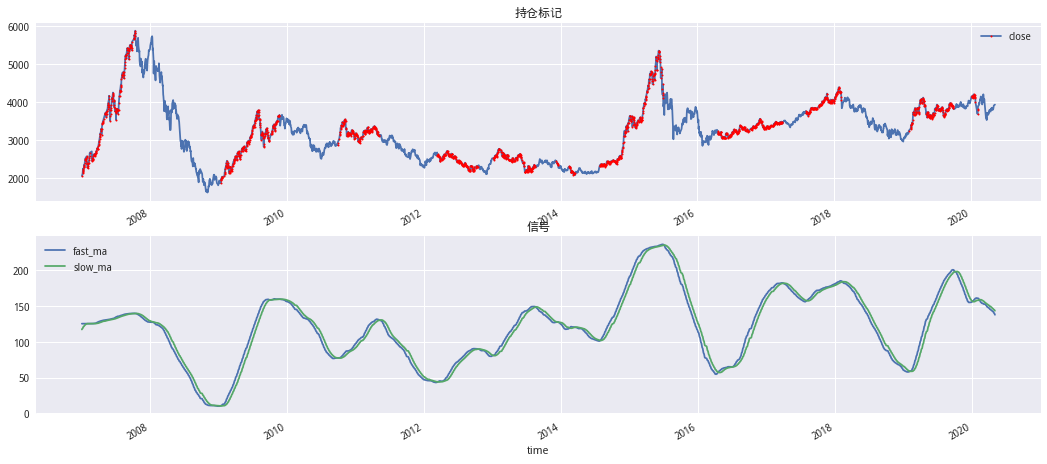

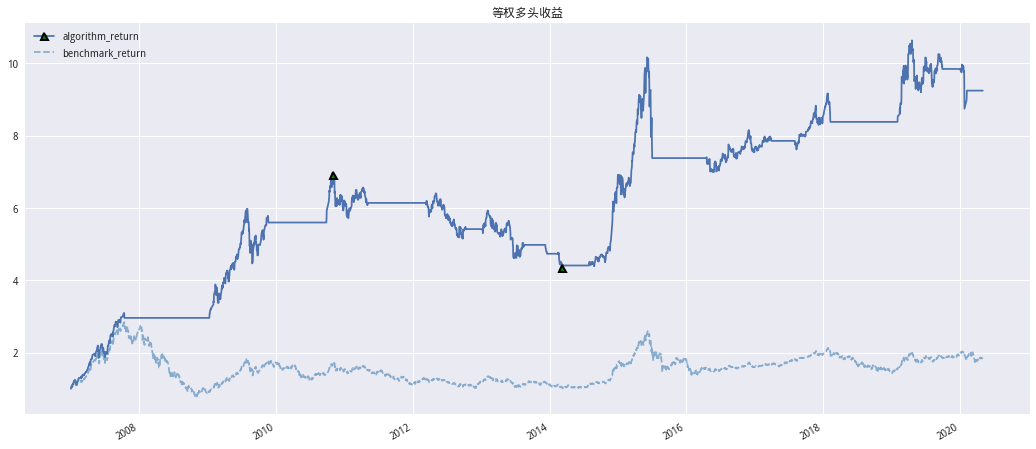

In [9]:
index_price = getattr(ma,'index_price')
fast_ma = getattr(ma,'fast_ma')
slow_ma = getattr(ma,'slow_ma')
flag = getattr(ma,'flag')

ma_avg_long = getattr(ma,'algorithm_cum')
ma_avg_long.name = '等权多头'

IndicatorPlot(index_price,fast_ma,slow_ma,flag)
CumPlot(index_price,ma_avg_long,'等权多头收益')

In [10]:
# 查看回测情况
pd.DataFrame(ma.GetRisk(),index=['160_150_25'])

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
160_150_25,13,0.6154,9.2423,0.1868,0.1837,0.7992,0.3739,20101105-20140307,0.4996


### 多空情况

In [11]:
def Singal(method):
    
    return CreatMaSingal(index_symbol,start_date,end_date,160,150,'avg',method)
    
risk_list = []
cum_list = []
flag_list = []

for label,method in zip(['等权多头','等权空头','等权多空'],['long','short','ls']):
    
    print(label)
    # 加权多头
    ma = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=Singal,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=150,
        N2=25,
        method=method)

    ma.backtest()  # 回测


    cum = getattr(ma,'algorithm_cum')
    cum.name = label
    
    rept = pd.Series(ma.GetRisk())
    rept.name = label
    
    flag_list.append(getattr(ma,'flag'))
    risk_list.append(rept)
    cum_list.append(cum)

等权多头
等权空头
等权多空


In [12]:
pd.DataFrame(risk_list)

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
等权多头,13.0,0.615400,9.2423,0.1868,0.1837,0.7992,0.3739,20101105-20140307,0.4996
等权空头,17.0,0.411800,1.5534,0.0348,0.2163,-0.0242,0.4431,20081103-20150722,0.0785
等权多空,30.0,0.466667,14.8777,0.2315,0.2738,0.6993,0.5142,20120104-20140827,0.4501


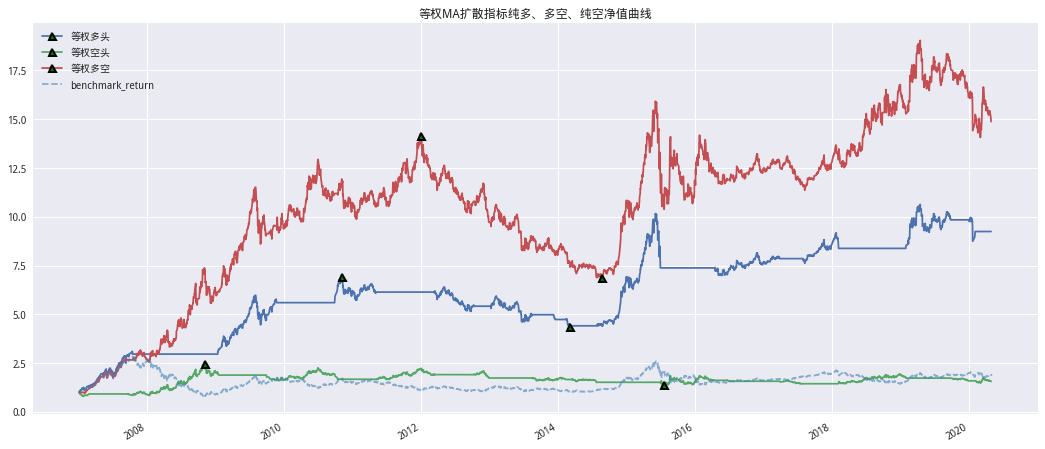

In [13]:
CumPlot(getattr(ma,'index_price'), cum_list, '等权MA扩散指标纯多、多空、纯空净值曲线')

## 流通市值加权处理

In [14]:
# 网格寻参
report_df = GetGridRiskReport(160,ma_mktcap_long)
# 查看夏普胜率最高的前5组
report_df.sort_values(['夏普','胜率'],ascending=False).head()

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
N|N1|N2,,,,,,,,,
160_80_30,16,0.6875,13.3856,0.2212,0.1794,1.0100,0.2653,20150605-20160524,0.8339
160_100_25,19,0.7368,12.1279,0.2119,0.1744,0.9861,0.2526,20090731-20090828,0.8389
160_90_20,17,0.7059,12.3652,0.2138,0.1765,0.9843,0.2040,20090731-20090818,1.0479
160_100_15,20,0.7000,12.2591,0.2129,0.1768,0.9781,0.2557,20090731-20100917,0.8329
160_80_25,16,0.6875,12.5910,0.2154,0.1796,0.9767,0.2830,20150605-20160524,0.7613


流通市值加权处理的情况下，由上表可知当N=160时N1,N2的最优参数分别为80,30

In [15]:
# 加权多头
ma1 = DiffusionIndicatorBackTest(
    symbol=index_symbol,
    singal_ser=ma_mktcap_long,
    start_date=start_date,
    end_date=end_date,
    cal_func=talib.MA,
    N1=80,
    N2=30,
    method='long')

ma1.backtest()  # 回测

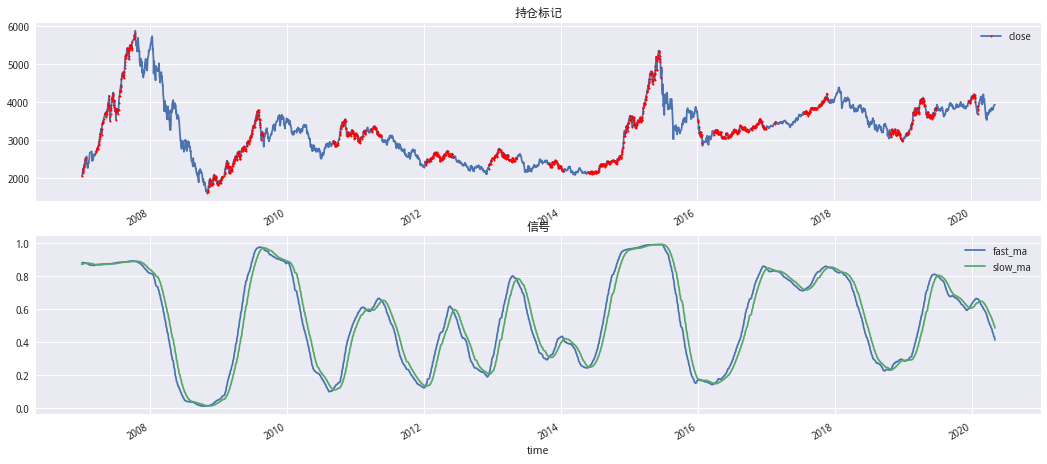

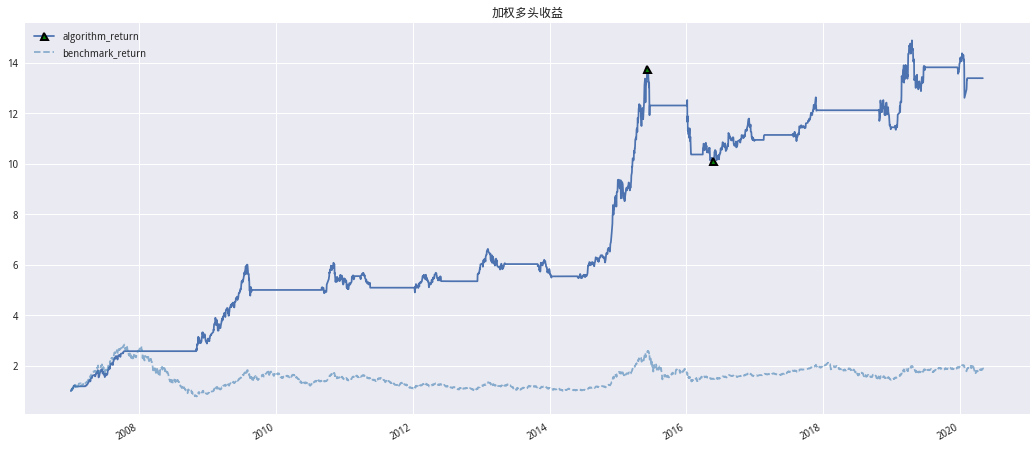

In [17]:
index_price = getattr(ma1,'index_price')
fast_ma = getattr(ma1,'fast_ma')
slow_ma = getattr(ma1,'slow_ma')
flag = getattr(ma1,'flag')

ma_mktcap_long = getattr(ma1,'algorithm_cum')
ma_mktcap_long.name = '加权多头'

IndicatorPlot(index_price,fast_ma,slow_ma,flag)
CumPlot(index_price,ma_mktcap_long,'加权多头收益')

In [18]:
# 查看回测情况
pd.DataFrame(ma1.GetRisk(),index=['160_80_30'])

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
160_80_30,16,0.6875,13.3856,0.2212,0.1794,1.01,0.2653,20150605-20160524,0.8339


### 多空情况

In [19]:
def Singal(method):
    
    return CreatMaSingal(index_symbol,start_date,end_date,160,150,'mktcap',method)
    

risk_list = []
cum_list = []
flag_list = []

for label,method in zip(['流通市值加权多头','流通市值加权空头','流通市值加权多空'],['long','short','ls']):
    
    print(label)
    # 加权多头
    ma = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=Singal,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=80,
        N2=30,
        method=method)

    ma.backtest()  # 回测


    cum = getattr(ma,'algorithm_cum')
    cum.name = label
    
    rept = pd.Series(ma.GetRisk())
    rept.name = label
    
    flag_list.append(getattr(ma,'flag'))
    risk_list.append(rept)
    cum_list.append(cum)

流通市值加权多头
流通市值加权空头
流通市值加权多空


In [20]:
pd.DataFrame(risk_list)

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
流通市值加权多头,16.0,0.68750,13.3856,0.2212,0.1794,1.0100,0.2653,20150605-20160524,0.8339
流通市值加权空头,16.0,0.50000,2.6246,0.0772,0.2164,0.1721,0.3687,20150825-20180123,0.2095
流通市值加权多空,32.0,0.59375,36.7717,0.3202,0.2680,1.0455,0.3933,20150825-20170810,0.8141


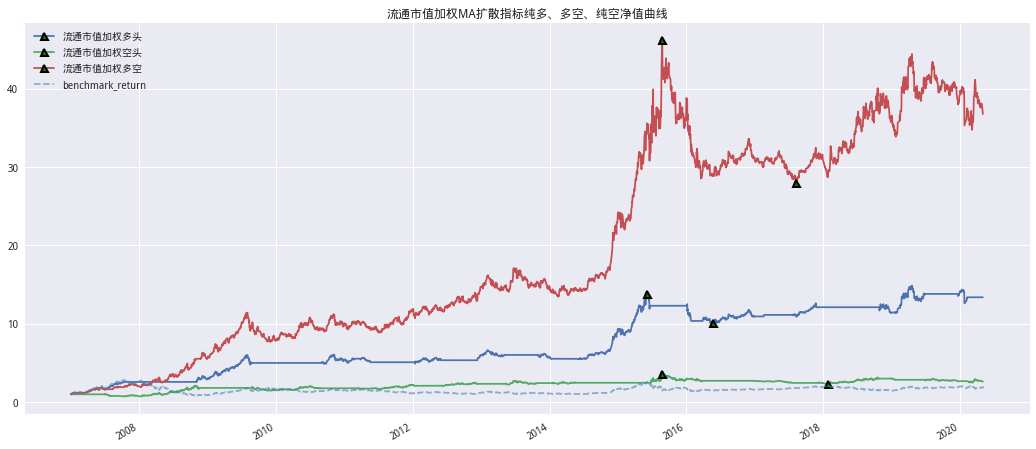

In [21]:
CumPlot(getattr(ma,'index_price'), cum_list, '流通市值加权MA扩散指标纯多、多空、纯空净值曲线')

# ROC指标

ROC(Price Rate of Change)又称变动率指标，是以今天的收盘价比较其 N 天前的收盘 价的差除以 N 天前的收盘（本质其实是 N 日 K 线的涨幅）进行计算的。是另一种 常用的构建扩散指标的技术指标。
判断个股多空头状态方法：对成分股价格计算其 N 日 ROC，当 ROC 值大于 0 时认 为个股处于多头状态，当 ROC 值小于 0 时认为个股处于空头状态。
这里我们使用沪深300指数计算扩散指标，并且使用移动平均的方法进行两次平滑。 一共有三个参数，N，N1，N2，计算 N 日 ROC，第一次平滑计算 N1 日移动平均线， 第二次平滑计算 N2 日移动平均线。参数的范围：N [60，250），单位为天，每隔 10 天取值；N1 [20，N），每取一个 N 值，N1 取值 20到 N 之间的数，每隔 10 天取值；N2 [10，N1），每隔5 天取值。其他的处理方式和使用MA指标时的方式一样。

## 数据获取

In [22]:
# 目标指数
index_symbol = '000300.XSHG'

# 复现时间设定
start_date, end_date = '2007-01-01', '2020-04-30'

# 计算等权信号
roc_avg_long = CreatROCSingal(index_symbol,start_date,end_date,100,90,'avg','long')

# 计算加权信号
roc_mktcap_long = CreatMaSingal(index_symbol,start_date,end_date,100,90,'mktcap','long')

## 等权处理

In [23]:
# 网格寻参
report_df = GetGridRiskReport(100,roc_avg_long)
# 查看夏普胜率最高的前5组
report_df.sort_values(['夏普','胜率'],ascending=False).head()

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
N|N1|N2,,,,,,,,,
100_90_30,16,0.7500,9.3049,0.1874,0.1827,0.8070,0.3158,20150605-20150707,0.5935
100_90_10,26,0.6154,8.2935,0.1769,0.1799,0.7611,0.3387,20090731-20121212,0.5224
100_80_45,14,0.7857,8.2342,0.1763,0.1824,0.7470,0.3158,20150605-20150707,0.5582
100_80_10,27,0.5185,7.9304,0.1731,0.1790,0.7439,0.4447,20150605-20160127,0.3893
100_80_35,15,0.8000,8.0104,0.1738,0.1819,0.7355,0.3158,20150605-20150707,0.5503


根据上面夏普及胜率优化结果N1=90,N2=30

In [24]:
# 等权多头
roc = DiffusionIndicatorBackTest(
    symbol=index_symbol,
    singal_ser=roc_avg_long,
    start_date=start_date,
    end_date=end_date,
    cal_func=talib.MA,
    N1=90,
    N2=30,
    method='long')

roc.backtest()  # 回测

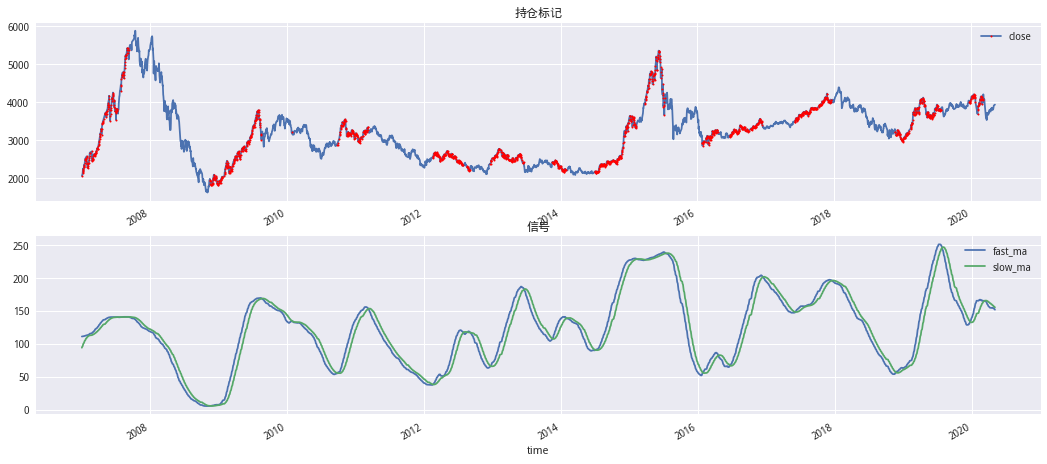

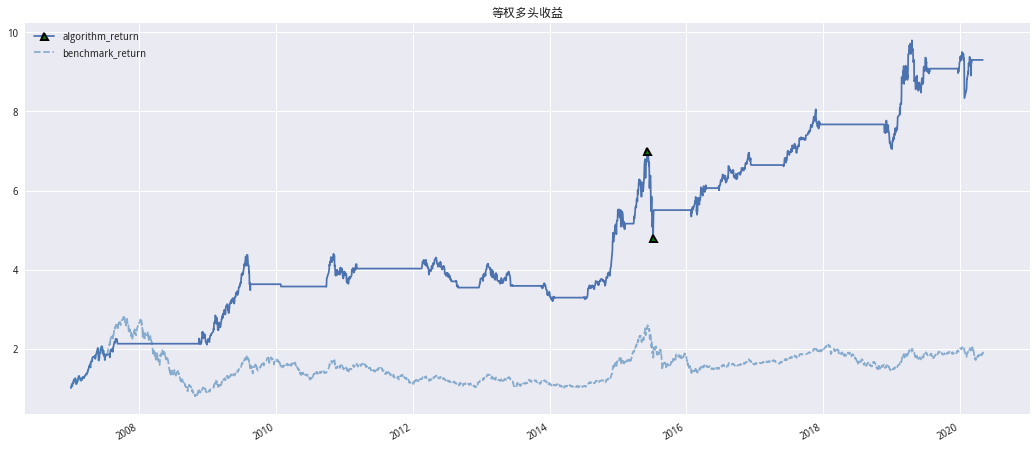

In [25]:
index_price = getattr(roc,'index_price')
fast_ma = getattr(roc,'fast_ma')
slow_ma = getattr(roc,'slow_ma')
flag = getattr(roc,'flag')

roc_avg_long = getattr(roc,'algorithm_cum')
roc_avg_long.name = '等权多头'

IndicatorPlot(index_price,fast_ma,slow_ma,flag)
CumPlot(index_price,roc_avg_long,'等权多头收益')

In [26]:
# 查看回测情况
pd.DataFrame(ma.GetRisk(),index=['100_90_30'])

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
100_90_30,32.0,0.59375,36.7717,0.3202,0.268,1.0455,0.3933,20150825-20170810,0.8141


### 多空情况

In [27]:
def Singal(method):
    
    return CreatROCSingal(index_symbol,start_date,end_date,100,90,'avg',method)
    

risk_list = []
cum_list = []
flag_list = []

for label,method in zip(['等权多头','等权空头','等权多空'],['long','short','ls']):
    
    print(label)
    # 加权多头
    roc = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=Singal,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=90,
        N2=30,
        method=method)

    roc.backtest()  # 回测


    cum = getattr(roc,'algorithm_cum')
    cum.name = label
    
    rept = pd.Series(roc.GetRisk())
    rept.name = label
    
    flag_list.append(getattr(roc,'flag'))
    risk_list.append(rept)
    cum_list.append(cum)

等权多头
等权空头
等权多空


In [28]:
pd.DataFrame(risk_list)

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
等权多头,16.0,0.750000,9.3049,0.1874,0.1827,0.8070,0.3158,20150605-20150707,0.5935
等权空头,17.0,0.470600,1.3641,0.0245,0.2211,-0.0703,0.4987,20070104-20071015,0.0490
等权多空,33.0,0.606061,13.4482,0.2219,0.2707,0.6720,0.3906,20120104-20140214,0.5680


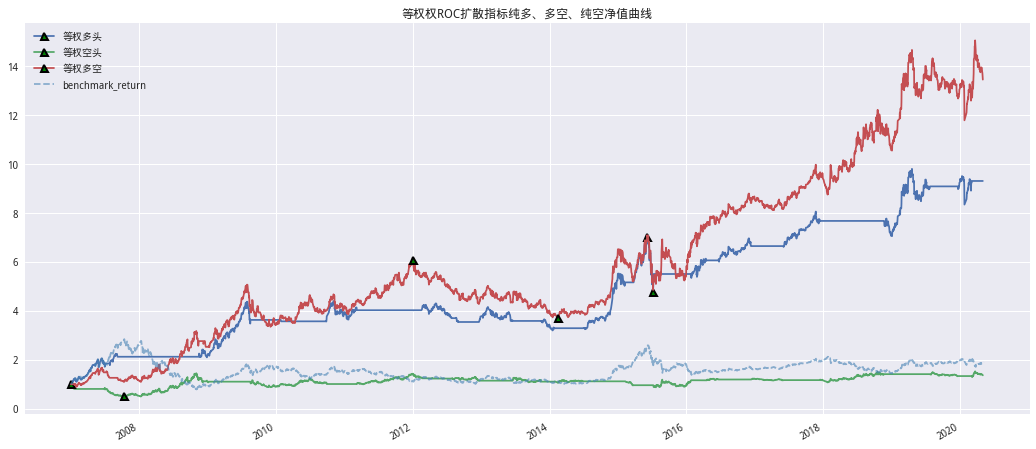

In [29]:
CumPlot(getattr(roc,'index_price'), cum_list, '等权权ROC扩散指标纯多、多空、纯空净值曲线')

## 流通市值加权处理

In [30]:
# 网格寻参
report_df = GetGridRiskReport(100,roc_mktcap_long)
# 查看夏普胜率最高的前5组
report_df.sort_values(['夏普','胜率'],ascending=False).head()

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
N|N1|N2,,,,,,,,,
100_90_80,12,0.9167,11.6621,0.2083,0.1778,0.9466,0.2260,20090731-20100917,0.9215
100_90_60,14,0.7143,11.5409,0.2073,0.1800,0.9293,0.2421,20151229-20160127,0.8564
100_90_75,13,0.7692,10.3162,0.1969,0.1798,0.8728,0.2575,20150605-20160127,0.7646
100_90_55,14,0.6429,10.1464,0.1954,0.1802,0.8623,0.2573,20150525-20160127,0.7594
100_90_85,12,0.9167,9.9972,0.1940,0.1800,0.8557,0.2689,20090731-20100917,0.7215


In [31]:
# 等权多头
roc = DiffusionIndicatorBackTest(
    symbol=index_symbol,
    singal_ser=roc_mktcap_long,
    start_date=start_date,
    end_date=end_date,
    cal_func=talib.MA,
    N1=90,
    N2=80,
    method='long')

roc.backtest()  # 回测

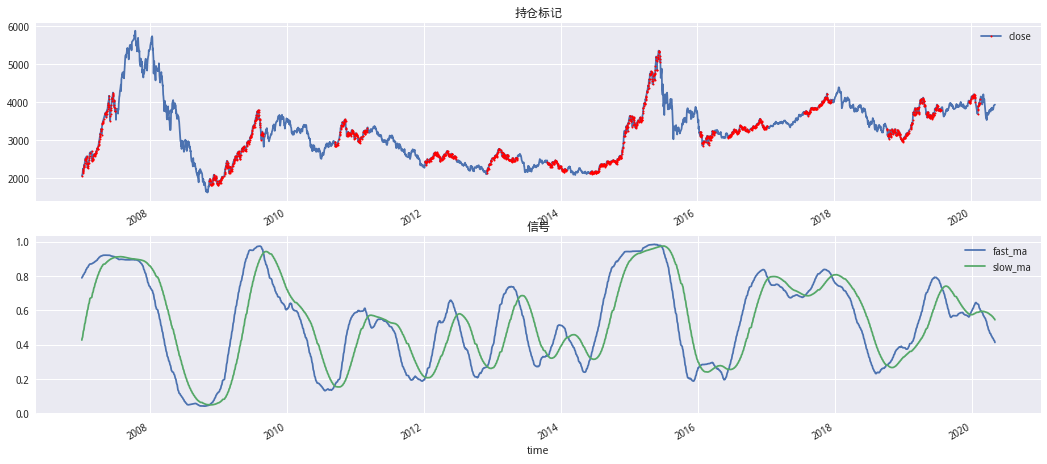

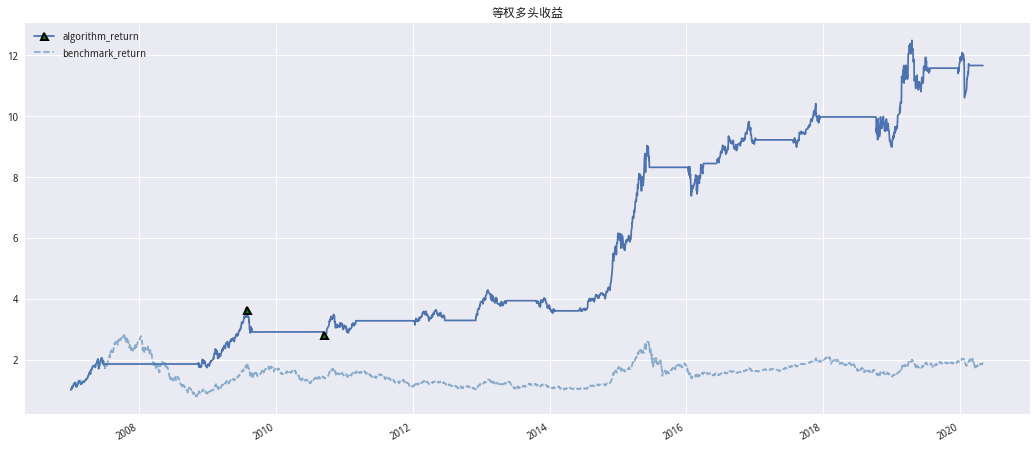

In [32]:
index_price = getattr(roc,'index_price')
fast_ma = getattr(roc,'fast_ma')
slow_ma = getattr(roc,'slow_ma')
flag = getattr(roc,'flag')

roc_avg_long = getattr(roc,'algorithm_cum')
roc_avg_long.name = '等权多头'

IndicatorPlot(index_price,fast_ma,slow_ma,flag)
CumPlot(index_price,roc_avg_long,'等权多头收益')

In [33]:
# 查看回测情况
pd.DataFrame(roc.GetRisk(),index=['100_90_80'])

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
100_90_80,12,0.9167,11.6621,0.2083,0.1778,0.9466,0.226,20090731-20100917,0.9215


### 多空情况

In [34]:
def Singal(method):
    
    return CreatROCSingal(index_symbol,start_date,end_date,100,90,'mktcap',method)
    

risk_list = []
cum_list = []
flag_list = []

for label,method in zip(['流通市值加权多头','流通市值加权空头','流通市值加权多空'],['long','short','ls']):
    
    print(label)
    # 加权多头
    roc = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=Singal,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=90,
        N2=80,
        method=method)

    roc.backtest()  # 回测


    cum = getattr(roc,'algorithm_cum')
    cum.name = label
    
    rept = pd.Series(roc.GetRisk())
    rept.name = label
    
    flag_list.append(getattr(roc,'flag'))
    risk_list.append(rept)
    cum_list.append(cum)

流通市值加权多头
流通市值加权空头
流通市值加权多空


In [35]:
pd.DataFrame(risk_list)

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
流通市值加权多头,13.0,0.615400,12.4674,0.2145,0.1804,0.9672,0.3074,20090731-20140307,0.6979
流通市值加权空头,13.0,0.384600,1.9797,0.0543,0.2207,0.0648,0.4652,20070104-20071015,0.1167
流通市值加权多空,26.0,0.423077,25.8845,0.2852,0.2716,0.9026,0.3664,20120504-20140409,0.7783


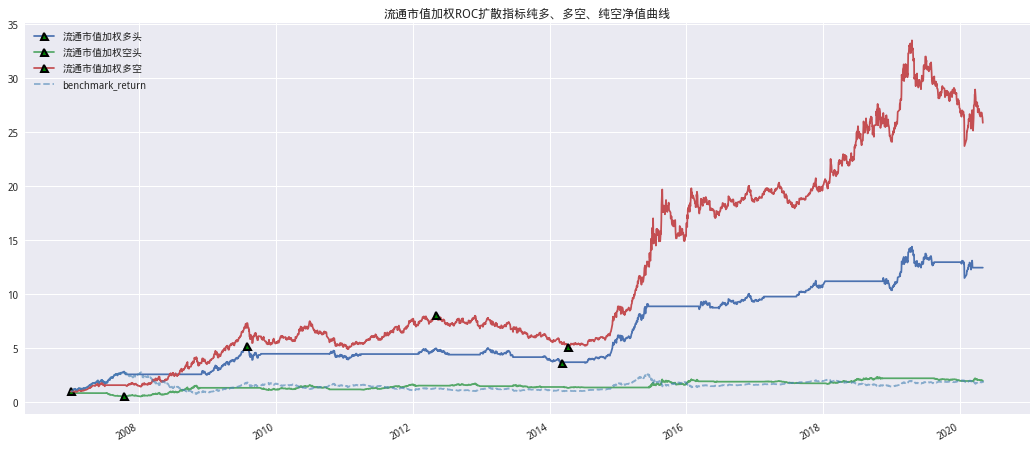

In [36]:
CumPlot(getattr(roc,'index_price'), cum_list, '流通市值加权ROC扩散指标纯多、多空、纯空净值曲线')

# KDJ扩散指标

KDJ 指标又叫随机指标。随机指标 KDJ 根据统计学原理，通过一个特定的周期内出 现过的最高价、最低价及最后一个计算周期的收盘价及这三者之间的比例关系，来 计算最后一个计算周期的未成熟随机值 RSV，然后根据平滑指数移动平均线的方法来计算 K值、D 值，并绘成曲线图来研判股票走势。


K线交叉 D 线：上涨趋势中，K值大于D值，K线向上突破D线时，为买进信号。下跌趋势中，K值小于D值，K线向下跌破 D 线时，为卖出信号。因此，在第 二种判断方法中，当 K线从下上穿 D 线时，认为个股进入多头状态，当 K 线从上下穿 D 线时，认为个股进入空头状态。

这里我们使用沪深 300 指数，一共需要三个参数，N，N1，N2。计算 N 日 RSV， 第一次移动平均平滑参数 N1，第二次移动平滑平均参数 N2。N 的取值范围 [150,330），每隔 10 取值，N1 的取值范围 [80,N），每隔 10 取值，N2 的取值范围[40，N1），每隔 5 取值，其余的处理方法和之前MA指标的处理方法相同。

**明确的说应该是KD扩散指标**

## 数据获取

In [43]:
# 目标指数
index_symbol = '000300.XSHG'

# 复现时间设定
start_date, end_date = '2007-01-01', '2020-04-30'

# 计算等权信号
kdj_avg_long = CreatKDJSingal(index_symbol,start_date,end_date,270,240,'avg','long')

# 计算加权信号
kdj_mktcap_long = CreatKDJSingal(index_symbol,start_date,end_date,270,240,'mktcap','long')

In [44]:
# 网格寻参
report_df = GetGridRiskReport(270,kdj_mktcap_long,80,40)
# 查看夏普胜率最高的前5组
report_df.sort_values(['夏普','胜率'],ascending=False).head()

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
N|N1|N2,,,,,,,,,
270_240_195,21,0.5238,14.5438,0.2290,0.1836,1.0297,0.3174,20090731-20121130,0.7216
270_240_200,21,0.5238,13.6993,0.2234,0.1833,1.0004,0.3416,20090731-20121130,0.6540
270_230_200,23,0.3913,13.3124,0.2207,0.1822,0.9919,0.3569,20090731-20121130,0.6184
270_240_185,24,0.4583,13.1888,0.2198,0.1837,0.9786,0.2587,20090731-20121130,0.8497
270_230_195,24,0.4583,12.9595,0.2182,0.1825,0.9761,0.3374,20090731-20121130,0.6466


In [45]:
kdj = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=kdj_mktcap_long,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=240,
        N2=195,
        method='long')

kdj.backtest()  # 回测

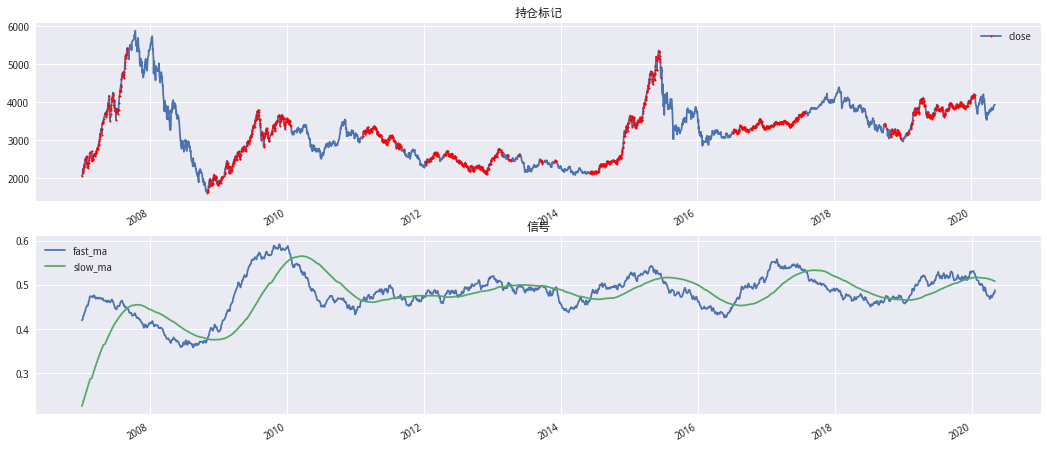

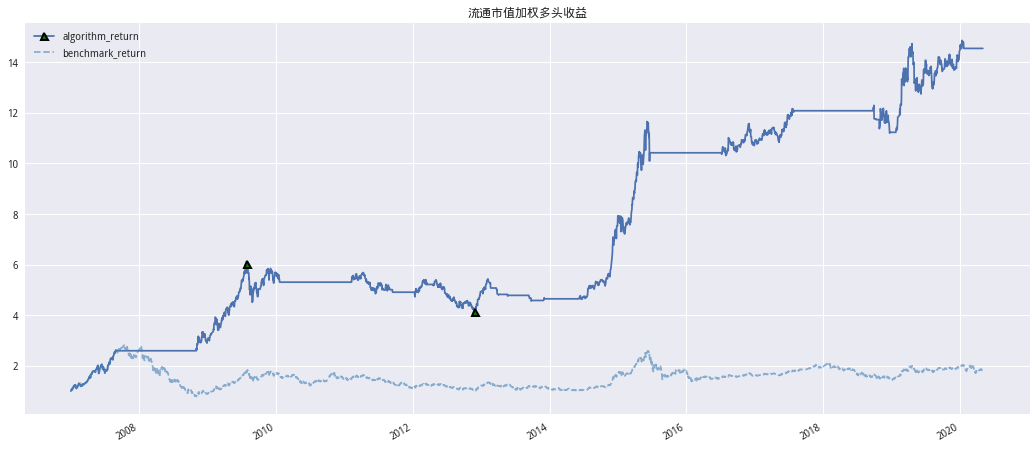

In [46]:
index_price = getattr(kdj,'index_price')
fast_ma = getattr(kdj,'fast_ma')
slow_ma = getattr(kdj,'slow_ma')
flag = getattr(kdj,'flag')

kdj_avg_long = getattr(kdj,'algorithm_cum')

IndicatorPlot(index_price,fast_ma,slow_ma,flag)
CumPlot(index_price,kdj_avg_long,'流通市值加权多头收益')

In [47]:
# 查看回测情况
pd.DataFrame(kdj.GetRisk(),index=['270_240_195'])

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
270_240_195,21,0.5238,14.5438,0.229,0.1836,1.0297,0.3174,20090731-20121130,0.7216


### 多空情况

In [49]:
def Singal(method):
    
    return CreatKDJSingal(index_symbol,start_date,end_date,270,240,'mktcap',method)
    

risk_list = []
cum_list = []
flag_list = []

for label,method in zip(['流通市值加权多头','流通市值加权空头','流通市值加权多空'],['long','short','ls']):
    
    print(label)
    # 加权多头
    roc = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=Singal,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=240,
        N2=195,
        method=method)

    roc.backtest()  # 回测


    cum = getattr(roc,'algorithm_cum')
    cum.name = label
    
    rept = pd.Series(roc.GetRisk())
    rept.name = label
    
    flag_list.append(getattr(roc,'flag'))
    risk_list.append(rept)
    cum_list.append(cum)

流通市值加权多头
流通市值加权空头
流通市值加权多空


In [50]:
pd.DataFrame(risk_list)

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
流通市值加权多头,21.0,0.5238,14.5438,0.2290,0.1836,1.0297,0.3174,20090731-20121130,0.7216
流通市值加权空头,29.0,0.4828,0.9838,-0.0010,0.2266,-0.1811,0.6514,20070104-20071219,-0.0016
流通市值加权多空,50.0,0.4000,16.7406,0.2427,0.2466,0.8220,0.3043,20100702-20101105,0.7977


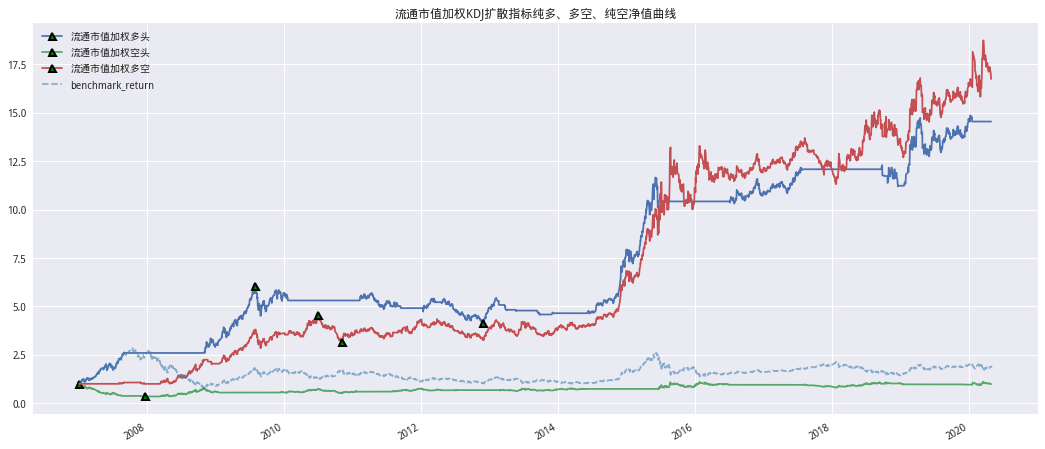

In [51]:
CumPlot(getattr(roc,'index_price'), cum_list, '流通市值加权KDJ扩散指标纯多、多空、纯空净值曲线')

# RSI扩散指标

相对强弱指标 RSI(Relative Strength Index)是衡量证券自身内在相对强度的指标。 相 对强弱指数RSI 是根据一定时期内上涨和下跌幅度之和的比率制作出的一种技术曲线。能够反映出市场在一定时期内的景气程度。

判断个股多空头状态方法：由于 RSI 指标的取值范围为[0，100]，我们可以采取同 KDJ 上下限策略同样的方法来进行判断，当个股 RSI 值大于 70 时，认为个股进入 多头状态，当 RSI 值小于 30 时，认为个股进入空头状态。
这里我们使用沪深 300 指数，一共需要三个参数，N，N1，N2。计算 N 日 RSI，第 一次移动平均平滑参数 N1，第二次移动平滑平均参数 N2。N 的取值范围[30，310）， 每隔 10 取值，N1 的取值范围[20，N），每隔 10 取值，N2 的取值范围[10，N1），每隔 5 取值，其余的处理方法和之前 MA指标的处理方法相同。

In [4]:
# 目标指数
index_symbol = '000300.XSHG'

# 复现时间设定
start_date, end_date = '2007-01-01', '2020-04-30'

# 计算加权信号
rsi_mktcap_long = CreatRSISingal(index_symbol,start_date,end_date,130,100,'mktcap','long')

In [5]:
# 网格寻参
report_df = GetGridRiskReport(130,rsi_mktcap_long,20,10)
# 查看夏普胜率最高的前5组
report_df.sort_values(['夏普','胜率'],ascending=False).head()

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
N|N1|N2,,,,,,,,,
120_110_85,13,0.4615,3.2722,0.0955,0.1635,0.3394,0.4032,20070618-20121130,0.2368
120_110_80,12,0.5833,3.1345,0.0919,0.1639,0.3165,0.5069,20070618-20121130,0.1812
120_110_75,15,0.4667,2.8895,0.0850,0.1706,0.2640,0.5107,20070618-20121130,0.1665
120_110_65,14,0.5714,2.8476,0.0838,0.1674,0.2617,0.5118,20080925-20110124,0.1637
120_110_45,19,0.6316,2.7672,0.0814,0.1702,0.2433,0.4580,20080828-20121130,0.1778


In [6]:
rsi = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=rsi_mktcap_long,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=110,
        N2=60,
        method='long')

rsi.backtest()  # 回测

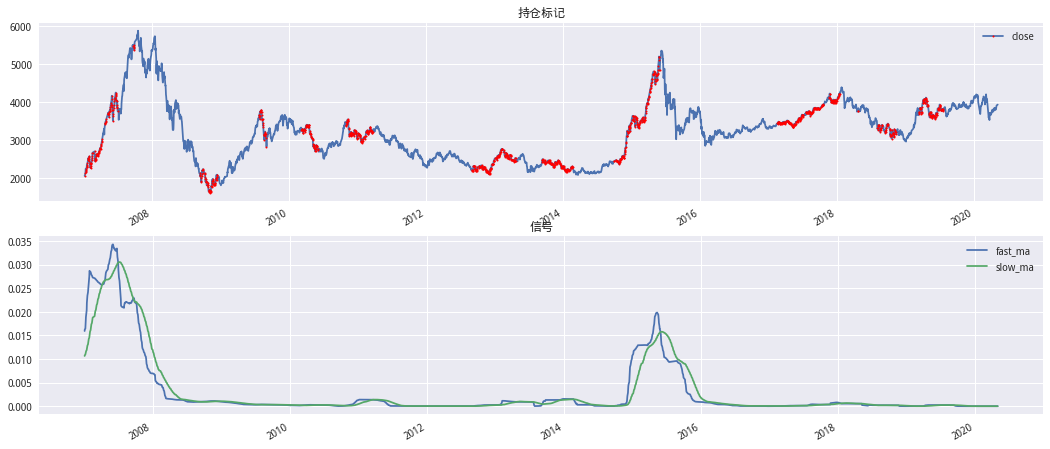

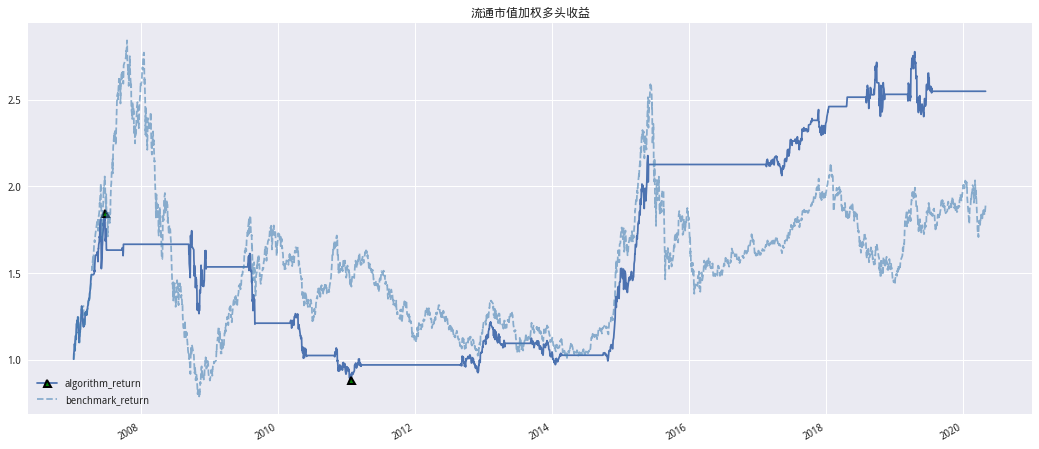

In [7]:
index_price = getattr(rsi,'index_price')
fast_ma = getattr(rsi,'fast_ma')
slow_ma = getattr(rsi,'slow_ma')
flag = getattr(rsi,'flag')

rsi_avg_long = getattr(rsi,'algorithm_cum')

IndicatorPlot(index_price,fast_ma,slow_ma,flag)
CumPlot(index_price,rsi_avg_long,'流通市值加权多头收益')

In [79]:
# 查看回测情况
pd.DataFrame(kdj.GetRisk(),index=['130_110_65'])

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
130_110_65,21,0.5238,14.5438,0.229,0.1836,1.0297,0.3174,20090731-20121130,0.7216


In [80]:
def Singal(method):
    
    return CreatKDJSingal(index_symbol,start_date,end_date,130,110,'mktcap',method)
    

risk_list = []
cum_list = []
flag_list = []

for label,method in zip(['流通市值加权多头','流通市值加权空头','流通市值加权多空'],['long','short','ls']):
    
    print(label)
    # 加权多头
    rsi = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=Singal,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=110,
        N2=65,
        method=method)

    rsi.backtest()  # 回测


    cum = getattr(rsi,'algorithm_cum')
    cum.name = label
    
    rept = pd.Series(roc.GetRisk())
    rept.name = label
    
    flag_list.append(getattr(rsi,'flag'))
    risk_list.append(rept)
    cum_list.append(cum)

流通市值加权多头
流通市值加权空头
流通市值加权多空


In [81]:
pd.DataFrame(risk_list)

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
流通市值加权多头,91.0,0.395600,1.1626,0.0115,0.1961,-0.1455,0.5464,20080111-20081105,0.0210
流通市值加权空头,92.0,0.369600,0.2968,-0.0892,0.2131,-0.6065,0.7249,20070104-20200304,-0.1231
流通市值加权多空,183.0,0.371585,0.3801,-0.0719,0.2627,-0.4259,0.7252,20070522-20200306,-0.0991


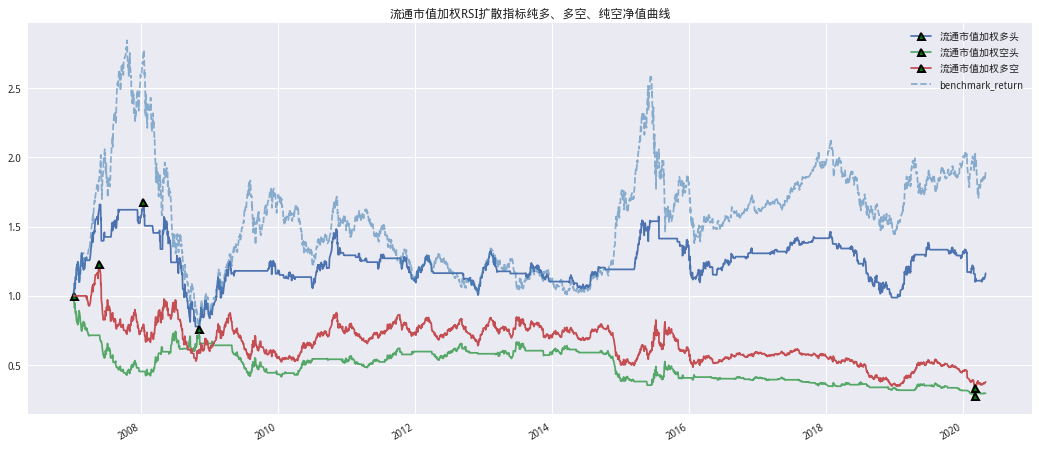

In [82]:
CumPlot(getattr(rsi,'index_price'), cum_list, '流通市值加权RSI扩散指标纯多、多空、纯空净值曲线')

# N日突破前期最高价

## 数据获取

In [11]:
# 目标指数
index_symbol = '000300.XSHG'

# 复现时间设定
start_date, end_date = '2007-01-01', '2020-04-30'

In [9]:
df_list = []

for i in range(40,251,10):
    
    high_mktcap_long = CreatStageHighSingal(index_symbol,start_date,end_date,i,90,'mktcap','long')
    
    # 网格寻参
    df_list.append(GetGridRiskReport(i,high_mktcap_long,20,10))

report_df = pd.concat(df_list)

# 查看夏普胜率最高的前5组
report_df.sort_values(['夏普','胜率'],ascending=False).head()

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
N|N1|N2,,,,,,,,,
230_220_15,29,0.5172,12.9664,0.2182,0.1817,0.9807,0.3357,20090731-20121130,0.6499
230_220_10,42,0.5714,12.3745,0.2138,0.1831,0.9492,0.3158,20090731-20121130,0.6770
240_220_15,33,0.5152,12.0209,0.2111,0.1819,0.9407,0.3582,20090731-20121130,0.5894
230_140_15,48,0.5625,11.1886,0.2044,0.1760,0.9342,0.3129,20101105-20121112,0.6534
200_180_15,35,0.6571,11.4593,0.2066,0.1811,0.9204,0.3156,20101105-20121119,0.6549


In [12]:
# 计算加权信号
high_mktcap_long = CreatStageHighSingal(index_symbol,start_date,end_date,230,220,'mktcap','long')

In [13]:
stage_high = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=high_mktcap_long,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=220,
        N2=15,
        method='long')

stage_high.backtest()  # 回测

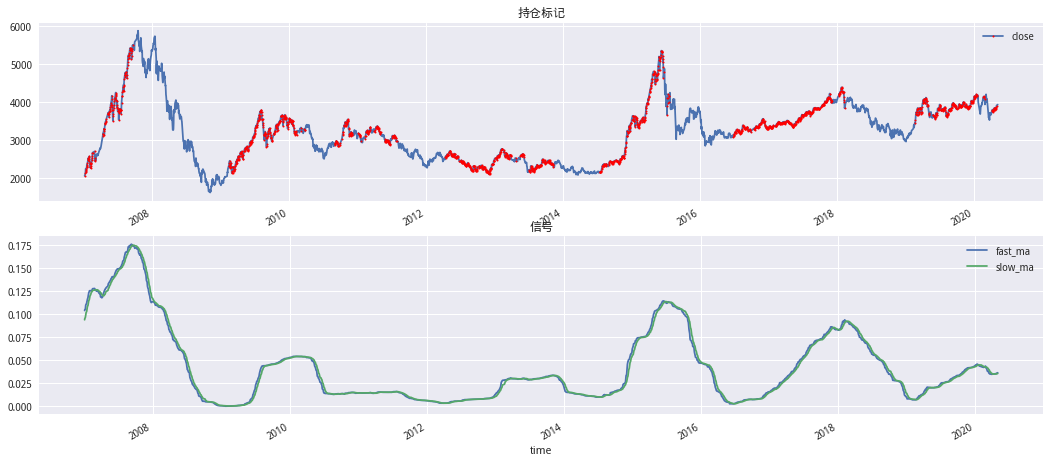

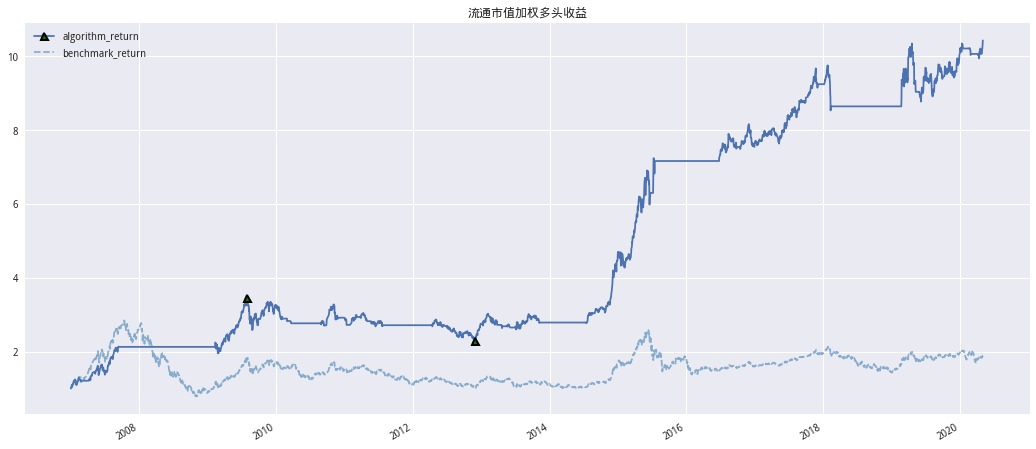

In [14]:
index_price = getattr(stage_high,'index_price')
fast_ma = getattr(stage_high,'fast_ma')
slow_ma = getattr(stage_high,'slow_ma')
flag = getattr(stage_high,'flag')

rsi_avg_long = getattr(stage_high,'algorithm_cum')

IndicatorPlot(index_price,fast_ma,slow_ma,flag)
CumPlot(index_price,rsi_avg_long,'流通市值加权多头收益')

In [15]:
# 查看回测情况
pd.DataFrame(stage_high.GetRisk(),index=['130_110_65'])

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
130_110_65,30,0.5333,10.4216,0.1978,0.1806,0.8739,0.3357,20090731-20121130,0.5893


### 多空

In [16]:
def Singal(method):
    
    return CreatStageHighSingal(index_symbol,start_date,end_date,220,15,'mktcap',method)
    

risk_list = []
cum_list = []
flag_list = []

for label,method in zip(['流通市值加权多头','流通市值加权空头','流通市值加权多空'],['long','short','ls']):
    
    print(label)
    # 加权多头
    bt = DiffusionIndicatorBackTest(
        symbol=index_symbol,
        singal_ser=Singal,
        start_date=start_date,
        end_date=end_date,
        cal_func=talib.MA,
        N1=220,
        N2=15,
        method=method)

    bt.backtest()  # 回测


    cum = getattr(bt,'algorithm_cum')
    cum.name = label
    
    rept = pd.Series(bt.GetRisk())
    rept.name = label
    
    flag_list.append(getattr(bt,'flag'))
    risk_list.append(rept)
    cum_list.append(cum)

流通市值加权多头
流通市值加权空头
流通市值加权多空


In [17]:
pd.DataFrame(risk_list)

,交易次数,胜率,累计净值,年化收益率,年化波动率,夏普,最大回撤,回撤时间,收益回撤比
流通市值加权多头,22.0,0.5000,6.0757,0.1490,0.1646,0.6624,0.3581,20101105-20131219,0.4162
流通市值加权空头,23.0,0.3913,0.5612,-0.0434,0.2442,-0.3414,0.6568,20070104-20071015,-0.0660
流通市值加权多空,45.0,0.4000,3.8733,0.1101,0.2590,0.2705,0.4364,20120104-20131230,0.2522


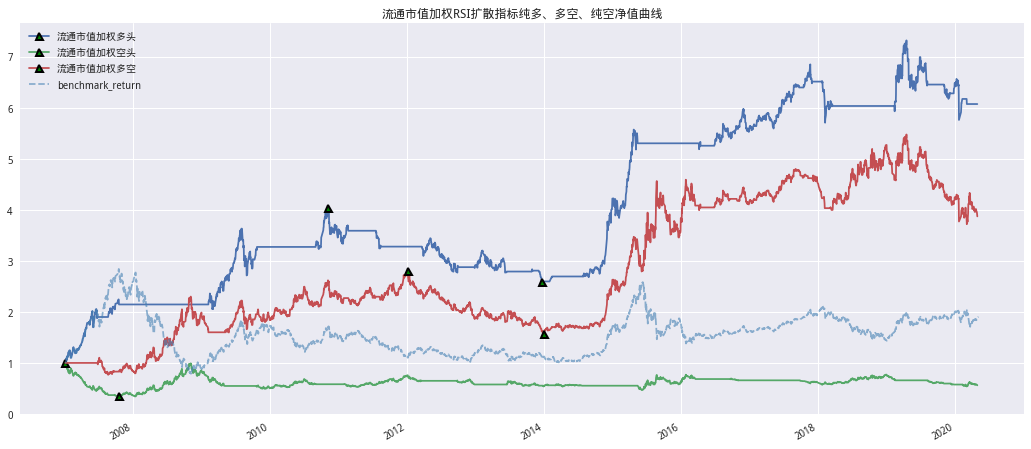

In [19]:
CumPlot(getattr(stage_high,'index_price'), cum_list, '流通市值加权RSI扩散指标纯多、多空、纯空净值曲线')